# [如何用Python和机器学习帮你决策？](http://www.jianshu.com/p/67a71e366516)
## 贷还是不贷：
每一行数据，都代表了之前的一次贷款信息。你琢磨了很久，终于弄明白了每一列究竟代表什么意思：

-    grade：贷款级别
-    sub_grade: 贷款细分级别
-    short_emp：一年以内短期雇佣
-    emp_length_num：受雇年限
-    home_ownership：居住状态（自有，按揭，租住）
-    dti：贷款占收入比例
-    purpose：贷款用途
-    term：贷款周期
-    last_delinq_none：贷款申请人是否有不良记录
-    last_major_derog_none：贷款申请人是否有还款逾期90天以上记录
-    revol_util：透支额度占信用比例
-    total_rec_late_fee：逾期罚款总额
-    safe_loans：贷款是否安全
最后一列，记录了这笔贷款是否按期收回。拿着以前的这些宝贵经验教训，主管希望你能够总结出贷款是否安全的规律。在面对新的贷款申请时，从容和正确应对。

这里需要找的这种规律，可以用决策树来表达。

下面我们开始动手实践。用Python做个决策树出来，辅助我们判断贷款风险。

## 准备

你需要`loans.csv`这个文件。如果一切正常，请把它移动到咱们的工作目录里面。

## 代码

首先，我们新建一个Python 笔记本，起名叫做loans-tree。

In [1]:
#为了让Python能够高效率处理表格数据，我们使用一个非常优秀的数据处理框架Pandas。
import pandas as pd

#然后我们把loans.csv里面的内容全部读取出来，存入到一个叫做df的变量里面。
df = pd.read_csv('loans.csv')

#我们看看df这个数据框的前几行，以确认数据读取无误。因为表格列数较多，屏幕上显示不完整，我们向右拖动表格，看表格最右边几列是否也正确读取。
df.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1
1,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0,-1
2,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0,-1
3,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0,-1
4,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0,-1


In [2]:
#统计一下总行数，看是不是所有行也都完整读取进来了。
df.shape

(46508, 13)

运行结果如下：(46508, 13)

每一条数据的最后一列`safe_loans`是个标记，告诉我们之前发放的这笔贷款是否安全。我们把这种标记叫做__目标(target)__，把前面的所有列叫做__“特征”(features)__。

下面我们就分别把特征和目标提取出来。依照机器学习领域的习惯，我们把特征叫做X，目标叫做y。

In [5]:
X = df.drop('safe_loans', axis=1)
y = df.safe_loans

#我们看一下特征数据X的形状:(46508, 12)除了最后一列，其他行列都在。符合我们的预期。我们再看看“目标”列。
#特征数据Y的形状:执行后显示如下结果：(46508,)逗号后面没有数字，指的是只有1列。：
print(X.shape,y.shape)

(46508, 12) (46508,)


注意这里有一个问题。Python下做决策树的时候，每一个特征都应该是数值（整型或者实数）类型的。但是我们一眼就可以看出，`grade, sub_grade, home_ownership`等列的取值都是类别`(categorical)`型。所以，必须经过一步转换，把这些类别都映射成为某个数值，才能进行下面的步骤。

那我们就开始映射吧：
这里，我们使用了LabelEncoder函数，成功地把类别变成了数值。小测验：在grade列下面，B被映射成了什么数字？

In [7]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
d = defaultdict(LabelEncoder)
X_trans = X.apply(lambda x: d[x.name].fit_transform(x))
X_trans.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee
0,2,13,1,1,3,97,0,1,1,1,107,0
1,5,26,0,5,2,552,9,1,1,1,349,0
2,1,9,1,1,3,1805,8,1,1,1,388,0
3,2,10,1,1,3,1005,2,0,1,1,952,0
4,1,6,0,4,3,703,8,0,1,1,583,0


下面我们需要做的事情，是把数据分成两部分，分别叫做训练集和测试集。

为什么这么折腾？

因为有道理。

想想看，如果期末考试之前，老师给你一套试题和答案，你把它背了下来。然后考试的时候，只是从那套试题里面抽取一部分考。你凭借超人的记忆力获得了100分。请问你学会了这门课的知识了吗？不知道如果给你新的题目，你会不会做呢？答案还是不知道。

所以考试题目需要和复习题目有区别。同样的道理，我们用数据生成了决策树，这棵决策树肯定对已见过的数据处理得很完美。可是它能否推广到新的数据上呢？这才是我们真正关心的。就如同在本例中，你的公司关心的，不是以前的贷款该不该贷。而是如何处理今后遇到的新贷款申请。

把数据随机拆分成训练集和测试集，在Python里只需要2条语句就够了。

In [13]:
from sklearn.model_selection import train_test_split #原教程这里需要修改，sklearn.cross_validation该模块在0.18版本中被弃用，支持所有重构的类和函数都被移动到的model_selection模块。 另请注意，新的CV迭代器的接口与本模块的接口不同。 此模块将在0.20中删除。
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, random_state=1)

#我们看看训练数据集和测试集的形状：
print(X_train.shape,X_test.shape)

(34881, 12) (11627, 12)


至此，一切数据准备工作都已就绪。我们开始呼唤Python中的scikit-learn软件包。决策树的模型，已经集成在内。只需要3条语句，直接调用就可以，非常方便。


In [14]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

好了，你要的决策树已经生成完了。

就是这么简单。任性吧？

可是，我怎么知道生成的决策树是个什么样子呢？眼见才为实！

这个……好吧，咱们把决策树画出来吧。注意这一段语句内容较多。以后有机会咱们再详细介绍。此处你把它直接抄进去执行就可以了。

见证奇迹的时刻到了：

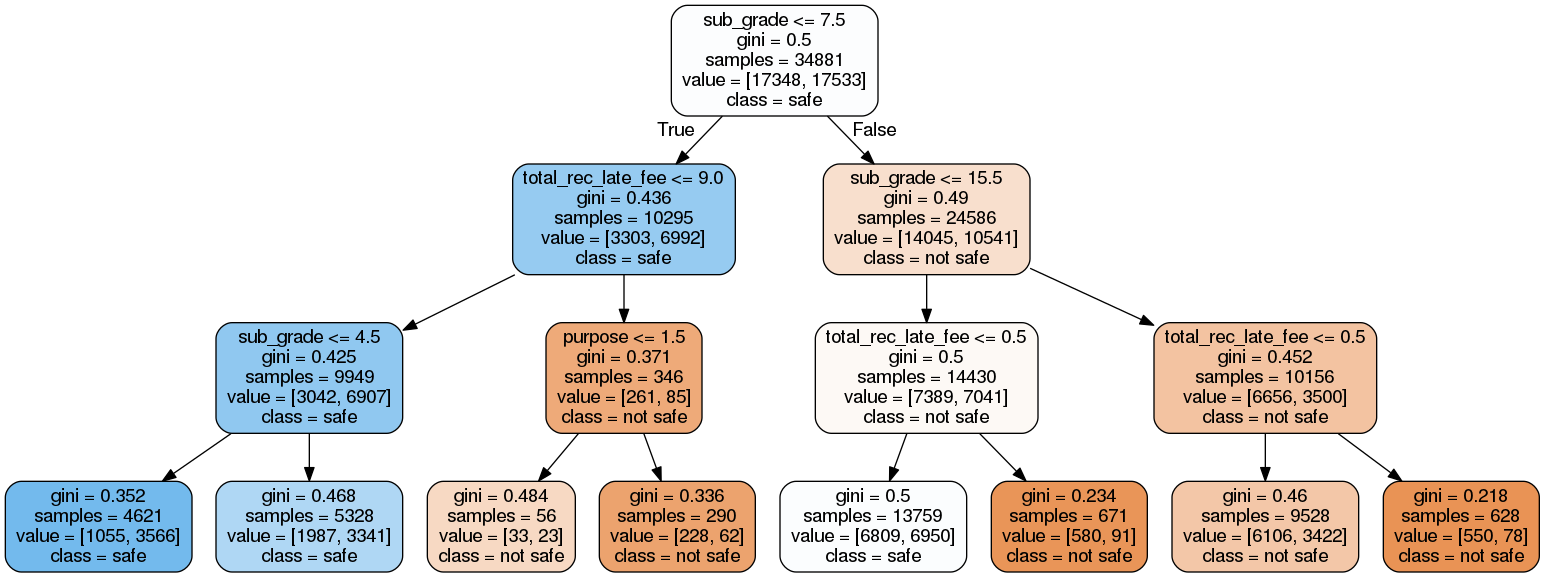

In [15]:
with open("safe-loans.dot", 'w') as f:
     f = tree.export_graphviz(clf,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(X_train),
                              class_names = ['not safe', 'safe'],
                              rounded = True,
                              filled= True )

from subprocess import check_call
check_call(['dot','-Tpng','safe-loans.dot','-o','safe-loans.png'])

from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont
img = Image.open("safe-loans.png")
draw = ImageDraw.Draw(img)
img.save('output.png')
PImage("output.png")

## 测试

欣喜若狂的你，在悄悄背诵什么？你说想把这棵决策树的判断条件背下来，然后去做贷款风险判断？

省省吧。都什么时代了，还这么喜欢背诵？

以后的决策，电脑可以自动化帮你完成了。

你不信？

我们随便从测试集里面找一条数据出来。让电脑用决策树帮我们判断一下看看。

In [20]:
test_rec = X_test.iloc[1,:]
print('电脑告诉我们，它调查后风险结果是这样的：',clf.predict([test_rec]),'之前提到过，1代表这笔贷款是安全的。实际情况如何呢？我们来验证一下。从测试集目标里面取出对应的标记：',y_test.iloc[1])

电脑告诉我们，它调查后风险结果是这样的： [1] 之前提到过，1代表这笔贷款是安全的。实际情况如何呢？我们来验证一下。从测试集目标里面取出对应的标记： 1


In [22]:
#下面我们验证一下，根据训练得来的决策树模型，贷款风险类别判断准确率究竟有多高。

from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf.predict(X_test))

0.61615205986066912

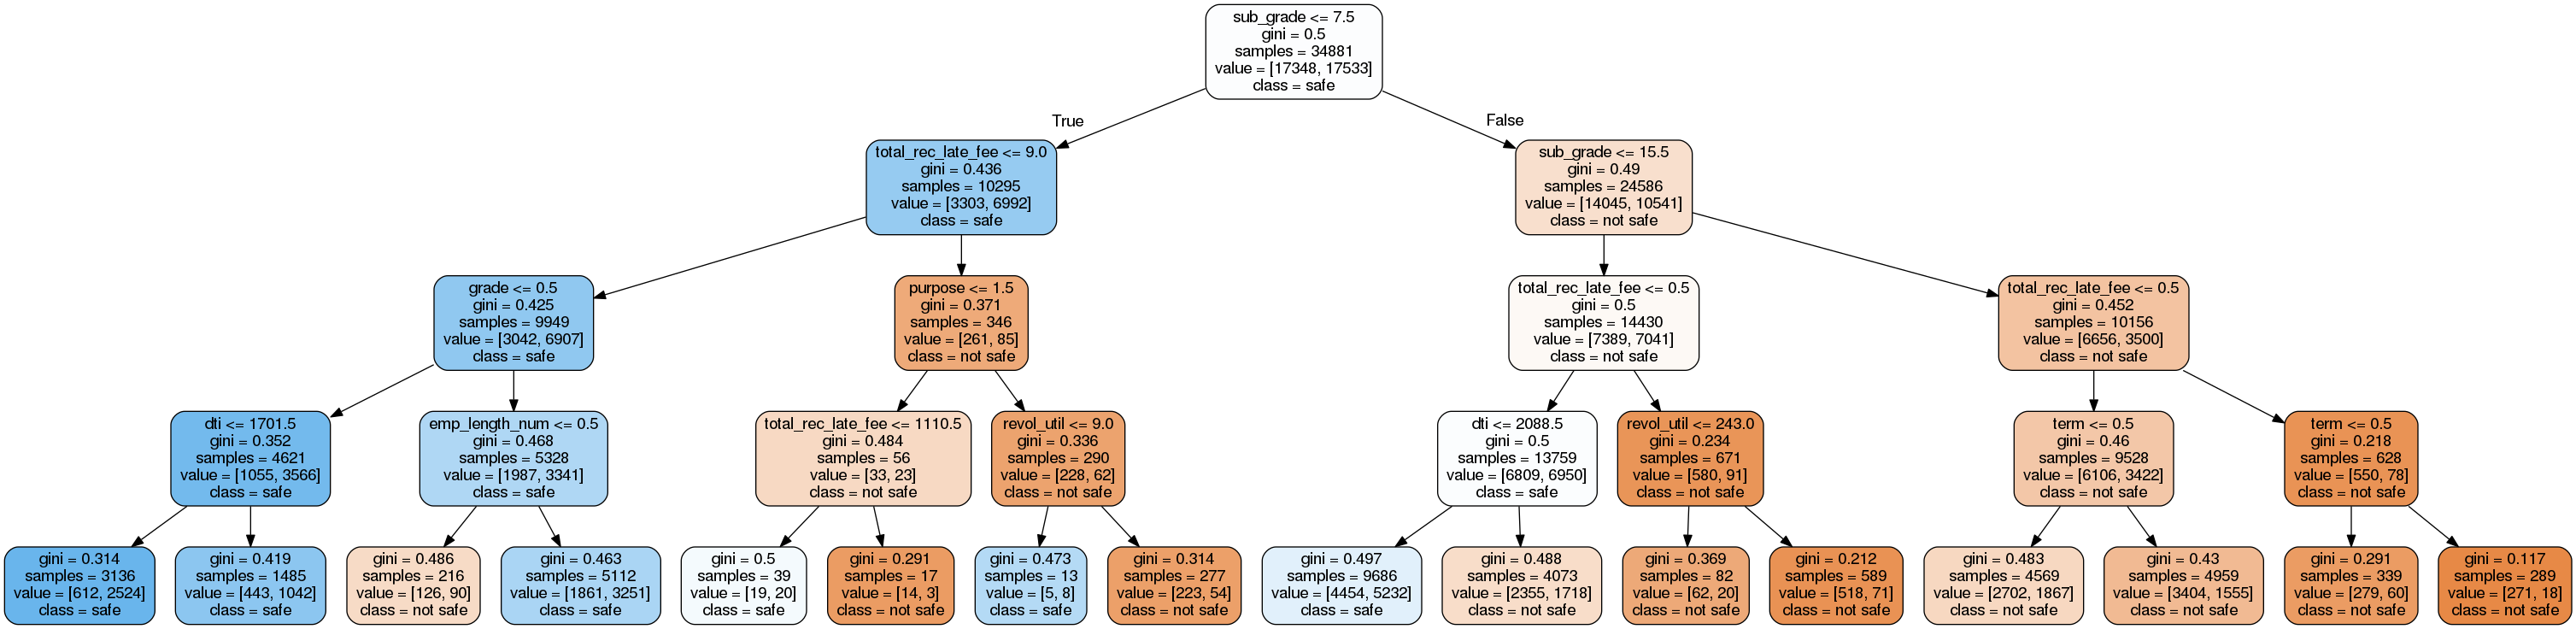

In [37]:
#模型才61%多的准确率啊，我修改一下，max_depth=4决策树深度为4看看效果
from sklearn import tree
clf2 = tree.DecisionTreeClassifier(max_depth=4)
clf2 = clf2.fit(X_train, y_train)

with open("safe-loans.dot", 'w') as f:
     f = tree.export_graphviz(clf2,
                              out_file=f,
                              max_depth = 4,
                              impurity = True,
                              feature_names = list(X_train),
                              class_names = ['not safe', 'safe'],
                              rounded = True,
                              filled= True )

from subprocess import check_call
check_call(['dot','-Tpng','safe-loans.dot','-o','safe-loans.png'])

from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont
img = Image.open("safe-loans.png")
draw = ImageDraw.Draw(img)
img.save('output.png')
PImage("output.png")

In [38]:
#下面我们验证一下，根据max_depth=4决策树深度为4的决策树模型，贷款风险类别判断准确率究竟有多高。

from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf2.predict(X_test))

0.63421346865055472

才从61%增加到了63%没啥进步啊。。。。。改成5\6\7\8\9\10试试看？要不我1~10全部都做一下试试看

In [36]:
from sklearn import tree
from sklearn.metrics import accuracy_score
clfi=[0]*21
for i in range(1,20):
    clfi[i] = tree.DecisionTreeClassifier(max_depth=i)
    clfi[i] = clfi[i].fit(X_train, y_train)
    print('决策树深度',i,'准确率',accuracy_score(y_test, clfi[i].predict(X_test)))

决策树深度 1 准确率 0.604111120667
决策树深度 2 准确率 0.60978756343
决策树深度 3 准确率 0.616152059861
决策树深度 4 准确率 0.634213468651
决策树深度 5 准确率 0.64530833405
决策树深度 6 准确率 0.644104240131
决策树深度 7 准确率 0.639975918122
决策树深度 8 准确率 0.644964307216
决策树深度 9 准确率 0.64006192483
决策树深度 10 准确率 0.638771824202
决策树深度 11 准确率 0.63189128752
决策树深度 12 准确率 0.626644878301
决策树深度 13 准确率 0.616926120237
决策树深度 14 准确率 0.610045583556
决策树深度 15 准确率 0.604197127376
决策树深度 16 准确率 0.600154812075
决策树深度 17 准确率 0.588715919842
决策树深度 18 准确率 0.583727530747
决策树深度 19 准确率 0.582351423411


为什么决策树深度增加而准确率下降了呢？我也不知道。。。